# Finite Size Scaling Analysis of 2D Ising model using data-collapse method

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import scipy
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import seaborn as sns
sns.set()

In [2]:
outdata = []
L_list = np.array([8,16,32])
T_list = np.arange(2.0, 2.51, 0.01)
for L in (L_list):
    file = open('output/seqlL' + str(L) + '_out.plt')
    csvreader = csv.reader(file)
    rows = []
    for row in csvreader:
        rows.append(row[:-1])
    outdata.append(rows)

outdata = np.float_(outdata)

# outdata[i][j][k]   
# i is the length 0 <-> L=8, 1 <-> L=16, 2 <-> L=32. 
# j is the temperature of interest. goes from 0 to 51 for 2.0 to 2.50
# k is the observable of interest. 6 is energy, 10 is |magnetization|, 18 for chi, 20 for C_v, 22 for U_4. 

In [3]:
def return_obs_data(j):
    obs = np.array([((outdata[i].T)[j]) for i in range(3)])
    obs_error = np.array([((outdata[i].T)[j+1]) for i in range(3)])
    return obs, obs_error

amag, amag_error = return_obs_data(10)
chi, chi_error = return_obs_data(18)
cv, cv_error = return_obs_data(20)
u_l, u_l_error = return_obs_data(22)

# Finding the Critical Temperature $T_c$

To find the critical temperature, we find the point at which the Binder's cumulant curves at different L values intersect. To do this, we subtract the the binder's cumulant at L=8 with L=16, at L=16 with L=32, at L=32 with L=8, and find the value of T at which the magnitude of their difference is lowest. Then we take the average of these points.

In [4]:
def get_T_c(u_l):
    T_list = np.arange(2.0, 2.51, 0.01)
    T_c = np.mean(np.array(([T_list[np.argmin(np.abs(u_l[0] - u_l[1]))], T_list[np.argmin(np.abs(u_l[1] - u_l[2]))], T_list[np.argmin(np.abs(u_l[2] - u_l[0]))]])))
    T_c = np.round(T_c,3)
    return(T_c)

T_c = get_T_c(u_l)

# Plotting $Q(L, t)$ vs $t$ curves

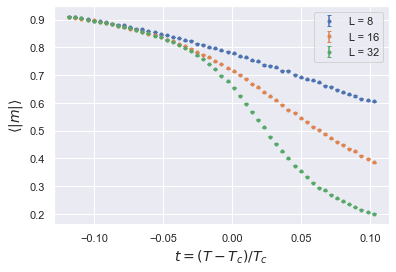

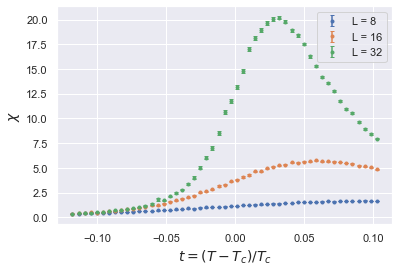

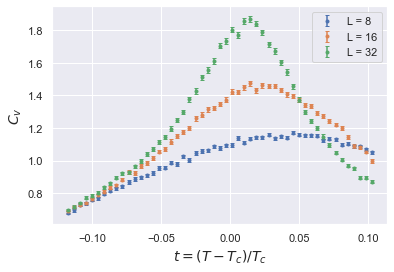

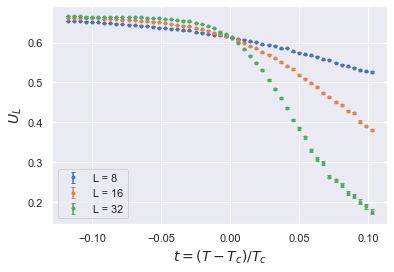

In [5]:
def plot_obs_vs_t(obs_string, obs, obs_error, name):
    plt.errorbar(((T_list-T_c)/T_c),obs[0], yerr = obs_error[0], fmt='.', capsize=2)
    plt.errorbar(((T_list-T_c)/T_c),obs[1], yerr = obs_error[1], fmt='.', capsize=2)
    plt.errorbar(((T_list-T_c)/T_c),obs[2], yerr = obs_error[2], fmt='.', capsize=2)
    plt.xlabel(r'$t = (T-T_c)/T_c$', fontsize=14)
    plt.ylabel(obs_string, fontsize=14)
    plt.legend(['L = 8', 'L = 16','L = 32'])
    #plt.savefig(name , dpi=(250), edgecolor='#f0f0f0', bbox_inches="tight") 
    plt.show()

plot_obs_vs_t(r'$\langle |m| \rangle$', amag, amag_error, "abs(mag)")
plot_obs_vs_t(r'$\chi$', chi, chi_error, "chi")
plot_obs_vs_t(r'$C_v$', cv, cv_error, "C_v")
plot_obs_vs_t(r'$U_L$', u_l, u_l_error, "U_L")

# Determining the Critical Exponents

To obtain the critical exponent $\nu$, we perform data-collapse method on $U_L \: L^{-1/\nu}\text{ vs } t\: L^{1\nu}$ curves. To obtain $\beta$ and $\gamma$, we follow the same approach for corresponding scaling laws for $\langle |m| \rangle$ and $\chi$, respectively. We do not evaluate the scaling exponent for $C_V$ because $\alpha = 0$ in the 2D Ising model, which is an anomaly. $C_V$ instead scales with a logarithmic function.

Our data-collapse methodology is naive at best right now, because we're simply minimizing the deviation $\sum \frac{\sigma(Q(L,\:t))}{\langle{Q(L,\:t)}\rangle}$. We can't use this to evaluate the errors in our estimate of the exponents since the estimates of $\langle |m| \rangle, \chi, C_V$ and $U_L$ itself have errors associated to them. A method to tackle this is proposed in https://www.iopb.res.in/~somen/SMB_papers/smb_seno_jpa34.pdf which I'll be implementing in the next few days.

In [6]:
def binder_cost_function(nu):
    L_list = np.array([8,16,32])
    T_list = np.arange(2.0, 2.51, 0.01)
    u_l, u_l_error = return_obs_data(22)
    T_c = get_T_c(u_l)
    
    x_low = np.amin(((T_list-T_c)/T_c)*L_list[0]**(1/nu))
    x_high =  np.amax(((T_list-T_c)/T_c)*L_list[0]**(1/nu))
    x = np.linspace(x_low, x_high, num = 100)
    f0 = interp1d(((T_list-T_c)/T_c)*L_list[0]**(1/nu),u_l[0], kind='cubic')
    f1 = interp1d(((T_list-T_c)/T_c)*L_list[1]**(1/nu),u_l[1], kind='cubic')
    f2 = interp1d(((T_list-T_c)/T_c)*L_list[2]**(1/nu),u_l[2], kind='cubic')

    binder_data = np.array([f0(x), f1(x), f2(x)]).T
    cost_sum = 0
    for i in range(100):
        deviation = np.std(binder_data[i])/np.mean(binder_data[i])
        cost_sum += deviation

    return cost_sum

In [7]:
nu = minimize(binder_cost_function, 0.3).x[0]

In [8]:
def obs_cost_function(zeta, nu, index_):
    #10 for abs(mag), 18 for chi, 20 for C_v. 
    
    L_list = np.array([8,16,32])
    T_list = np.arange(2.0, 2.51, 0.01)
    obs, obs_error = return_obs_data(index_)
    T_c = get_T_c(u_l)
    
    x_low = np.amin(((T_list-T_c)/T_c)*L_list[0]**(1/nu))
    x_high =  np.amax(((T_list-T_c)/T_c)*L_list[0]**(1/nu))
    x = np.linspace(x_low, x_high, num = 100)
    
    f0 = interp1d(((T_list-T_c)/T_c)*L_list[0]**(1/nu),obs[0]/(L_list[0]**(zeta/nu)), kind='cubic')
    f1 = interp1d(((T_list-T_c)/T_c)*L_list[1]**(1/nu),obs[1]/(L_list[1]**(zeta/nu)), kind='cubic')
    f2 = interp1d(((T_list-T_c)/T_c)*L_list[2]**(1/nu),obs[2]/(L_list[2]**(zeta/nu)), kind='cubic')

    obs_data = np.array([f0(x), f1(x), f2(x)]).T
    cost_sum = 0
    for i in range(100):
        deviation = np.std(obs_data[i])/np.mean(obs_data[i])
        cost_sum += deviation

    return cost_sum

In [9]:
beta = minimize(obs_cost_function, 0.3, args = (nu, 10)).x[0]
gamma = minimize(obs_cost_function, 0.3, args = (nu, 18)).x[0]
alpha_prime = minimize(obs_cost_function, 0.3, args = (nu, 20)).x[0]

# However, as we know, the critical exponent α exponent of 2D Ising Model is α=0, which is an anomaly.
# We might get a scaling exponent, but that is only valid for a small range of lattice sizes.
# Instead of L^α/ν, the C_v has a dependence of a ln(L) factor scaling. 

In [10]:
def data_collapse(T_list, L_list, T_c, nu, index_, zeta):
    obs, obs_error = return_obs_data(index_)

    if (index_ == 10 or index_ == 18  or index_ == 22):
        for i in range(3):
            plt.plot(((T_list-T_c)/T_c)*(L_list[i]**(1/nu)), obs[i]/(L_list[i]**(zeta/nu)), '.')
            
    elif(index_ == 20):
        for i in range(3):
            plt.plot(((T_list-T_c)/T_c)*(L_list[i]**(1/nu)), obs[i]/(np.log(L_list[i])), '.')

    x_low = np.amin(((T_list-T_c)/T_c)*L_list[2]**(1/nu))
    x_high =  np.amax(((T_list-T_c)/T_c)*L_list[2]**(1/nu))
    
    plt.xlim([x_low, x_high])
        
    if (index_ == 10):
        plt.ylabel(r'$\frac{\langle |m| \rangle}{L^{-\beta/\nu}}$', fontsize=18)
        name = "abs(mag) data collapse"
    elif(index_ == 18):
        plt.ylabel(r'$\frac{\chi}{L^{\gamma/\nu}}$', fontsize=18)
        name = "chi data collapse"
    elif(index_ == 20):
        plt.ylabel(r'$\frac{C_v}{\ln(L)}$', fontsize=18)
        name = "C_v data collapse"
    elif(index_ == 22):
        plt.ylabel(r'$U_L$', fontsize=14)
        name = "U_L data collapse"
        
    plt.xlabel(r'$t\: L^{1/\nu}$', fontsize=14)
    plt.legend(['L = 8', 'L = 16','L = 32'])
    #plt.savefig(name , dpi=(250), edgecolor='#f0f0f0', bbox_inches="tight") 
    plt.show()

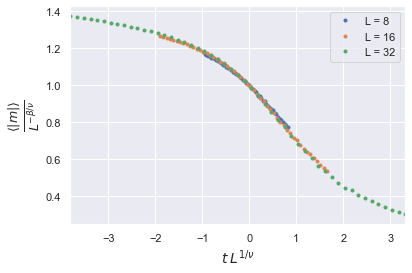

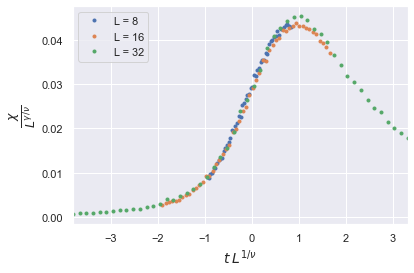

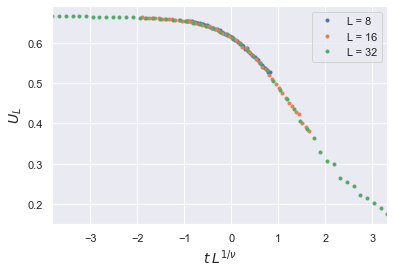

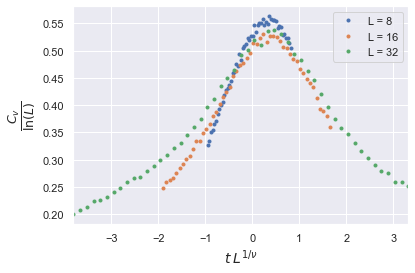

Critical Exponents of 2D Ising Model 

Tc = 2.267
α = 0
ν =  0.998
β =  0.117
γ =  1.755


In [11]:
data_collapse(T_list, L_list, T_c, nu, 10, beta)
data_collapse(T_list, L_list, T_c, nu, 18, gamma)
data_collapse(T_list, L_list, T_c, nu, 22, 0)
data_collapse(T_list, L_list, T_c, nu, 20, alpha_prime)

print('Critical Exponents of 2D Ising Model', '\n')
print('Tc =', np.round(T_c, 3))
print('α = 0')
print('ν = ', np.round(nu, 3))
print('β = ', np.round(-beta, 3))
print('γ = ', np.round(gamma, 3))

# Estimates of the Critical Exponents of 2D Ising Model
\begin{equation*}
   \boxed{
   \begin{gathered}
T_c = 2.267 \\
\nu =  0.998 \\
\alpha = 0 \\
\beta =  0.117 \\
\gamma =  1.755
   \end{gathered}
   }
\end{equation*}